# CS 136 Day 17 - Gaussian Mixture Models


## Outline

* [Part 1: plotting a mixture of Gaussians](#part1)
* [Part 2: Numerically stable computation of log GMM pdf via logsumexp](#part2)


# Part 1: Plotting a mixture of Gaussians

In [ ]:
import numpy as np
import scipy.stats as stats
from scipy.special import logsumexp

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

In [ ]:
## Number of states
K = 2

In [ ]:
## Frequencies of each component
pi_K = np.asarray([0.8, 0.2])

In [ ]:
pi_K

array([0.8, 0.2])

In [ ]:
## Means and stddev of each component
mu_K = np.asarray([-2., 1])
sigma_K = np.asarray([1, 1.])

In [ ]:
xgrid_G = np.linspace(-6, 6, 501)

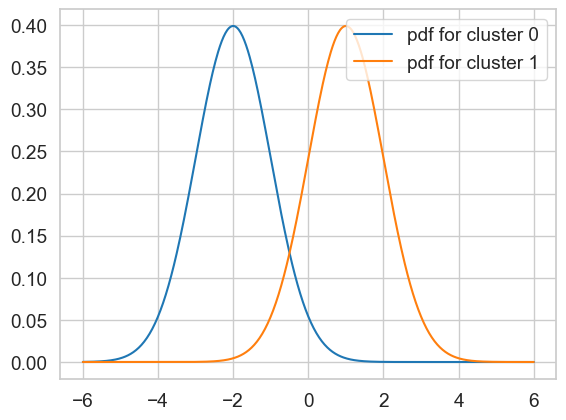

In [ ]:
# show the individual component PDFs

for k in range(K):
    plt.plot(xgrid_G, stats.norm.pdf(xgrid_G, mu_K[k], sigma_K[k]), label='pdf for cluster %d' % k)
plt.legend(loc='upper right');

## Simple implementation of the GMMPDF function

In [ ]:
def calc_gmmpdf(x_G, pi_K, mu_K, sigma_K):
    pdf_G = np.zeros_like(x_G)
    for k in range(K):
        pdf_G += pi_K[k] * stats.norm.pdf(x_G, mu_K[k], sigma_K[k])
    return pdf_G

In [ ]:
def plot_gmmpdf(x_G, pi_K, mu_K, sigma_K):
    print(" pi: ", pi_K)
    print(" mu: ", mu_K)
    print("sig: ", sigma_K)
    plt.plot(x_G, calc_gmmpdf(x_G, pi_K, mu_K, sigma_K))

## Visualizations of GMMPDF function

 pi:  [0.8 0.2]
 mu:  [-2.  1.]
sig:  [1. 1.]


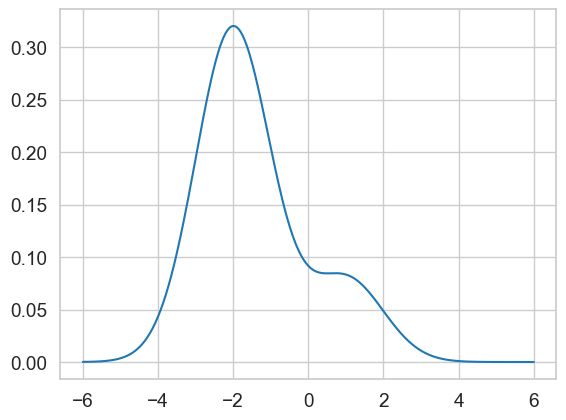

In [ ]:
plot_gmmpdf(xgrid_G, pi_K, mu_K, sigma_K)

 pi:  [0.1, 0.9]
 mu:  [-2.  1.]
sig:  [1. 1.]


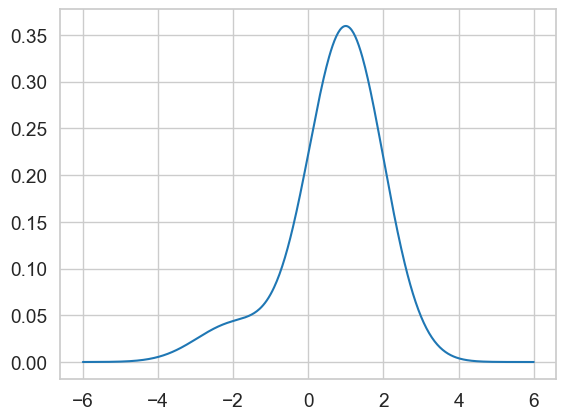

In [ ]:
# What if the pi values were different?
plot_gmmpdf(xgrid_G, [.1, .9], mu_K, sigma_K)

 pi:  [0.8 0.2]
 mu:  [-2.  1.]
sig:  [0.2, 0.4]


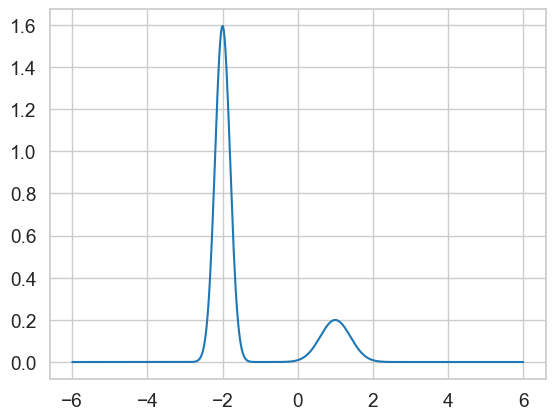

In [ ]:
# What if the sigma values were different?
plot_gmmpdf(xgrid_G, pi_K, mu_K, [.2, .4])

# Part 1: Numerical issues with computing the log pdf

In [ ]:
# Consider the following initialization

pi_K = np.asarray([0.8, 0.2])
mu_K = np.asarray([-2, 1.])
sigma_K = np.asarray([0.01, 0.01]) # pretty small variances!

In [ ]:
calc_gmmpdf(0.0, pi_K, mu_K, sigma_K)

array(0.)

### Discussion: What can go wrong when the pdf numerically evaluates to zero?

*Hint*: If we were computing *gradients* of this loss, what would we get? Could we find an informative direction to move these parameters to fit the data better?

TODO discuss and fill

## But does the logpdf of any individual component ever go to zero?

In [ ]:
stats.norm.logpdf(0.0, mu_K[0], sigma_K[0])

-19996.313768347216

In [ ]:
stats.norm.logpdf(0.0, mu_K[1], sigma_K[1])

-4996.313768347217

### Discussion: If you were optimizing an individual Gaussian component, would the above losses yield gradients that tell you how to move parameters to fit the data better?

Yes! The loss is non-zero, and the gradient would also be non-zero.

## Try naive way to compute the loss

In [ ]:
def calc_log_gmmpdf__naive(x_G, pi_K, mu_K, sigma_K):
    pdf_G = np.zeros_like(x_G)
    for k in range(K):
        pdf_G += pi_K[k] * np.exp(stats.norm.logpdf(x_G, mu_K[k], sigma_K[k]))
    return np.log(pdf_G)

In [ ]:
def plot_loggmmpdf(x_G, pi_K, mu_K, sigma_K, logpdf=calc_log_gmmpdf__naive):
    print(" pi: ", pi_K)
    print(" mu: ", mu_K)
    print("sig: ", sigma_K)
    plt.plot(x_G, np.exp(logpdf(x_G, pi_K, mu_K, sigma_K)))

In [ ]:
calc_log_gmmpdf__naive(np.asarray([0.0]), pi_K, mu_K, sigma_K)

/var/folders/_7/xr25dhrs43z7nbtp2n3h_chw0000gn/T/ipykernel_97116/144330975.py:5: RuntimeWarning: divide by zero encountered in log
  return np.log(pdf_G)


array([-inf])

 pi:  [0.8 0.2]
 mu:  [-2.  1.]
sig:  [0.01 0.01]


/var/folders/_7/xr25dhrs43z7nbtp2n3h_chw0000gn/T/ipykernel_97116/144330975.py:5: RuntimeWarning: divide by zero encountered in log
  return np.log(pdf_G)


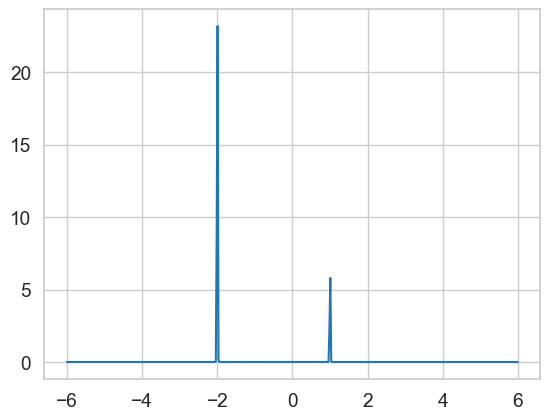

In [ ]:
plot_loggmmpdf(xgrid_G, pi_K, mu_K, sigma_K)

## Try smart way to compute the loss with logsumexp trick

In [ ]:
def calc_log_gmmpdf__logsumexp(x_G, pi_K, mu_K, sigma_K):
    logpdf_G = np.zeros_like(x_G)
    for g in range(x_G.size):
        a_K = np.log(pi_K)
        for k in range(K):
            a_K[k] += stats.norm.logpdf(x_G[g], mu_K[k], sigma_K[k])
        logpdf_G[g] = logsumexp(a_K)
    return logpdf_G

In [ ]:
calc_log_gmmpdf__logsumexp(np.asarray([0.0]), pi_K, mu_K, sigma_K)

array([-4997.92320626])

 pi:  [0.8 0.2]
 mu:  [-2.  1.]
sig:  [0.01 0.01]


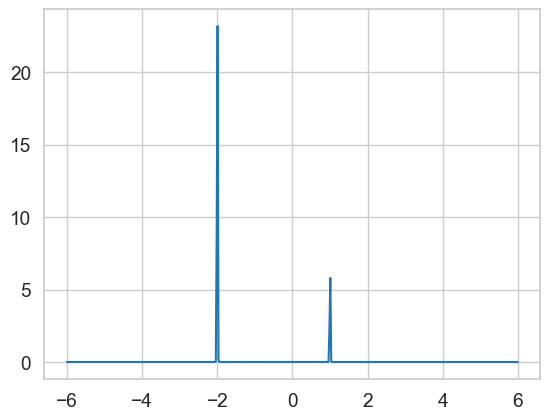

In [ ]:
plot_loggmmpdf(xgrid_G, pi_K, mu_K, sigma_K, logpdf=calc_log_gmmpdf__logsumexp)